In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import seaborn as sns

plt.style.use("ggplot")
tf.random.set_seed(1)

## Import data

In [197]:
# os.chdir(os.path.join(os.getcwd(), "titanic data"))
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

full_df = pd.concat([train, test])
print(len(full_df.index), len(train.index), len(test.index))

1309 891 418


In [198]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [199]:
# there are some ages missing. Let's replace those with the mean
mean_age = full_df["Age"].mean() # mean age

# Fill missing values in column A with the mean
train["Age"] = train["Age"].fillna(mean_age)  # maybe it would be better to have it draw from a normal dist w those characteristics?
train["Embarked"] = train["Embarked"].fillna(full_df["Embarked"].value_counts().index[0])  # replace missing embarked with most common

# do same for test data
test["Age"] = train["Age"].fillna(mean_age)
test["Embarked"] = train["Embarked"].fillna(full_df["Embarked"].value_counts().index[0])

print(train.info())
print(test.info())

# still need to figure out how cabin fits into this, and what to do about the nulls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

In [200]:
# there's a fare missing from test dataset. I'll put the average fare in as a replacement
test["Fare"] = train["Fare"].fillna(full_df["Fare"].mean())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [201]:

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.735277,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002218,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


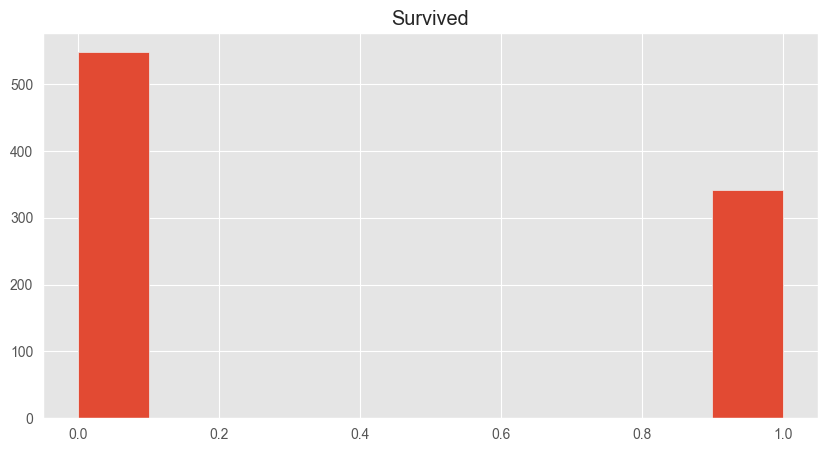

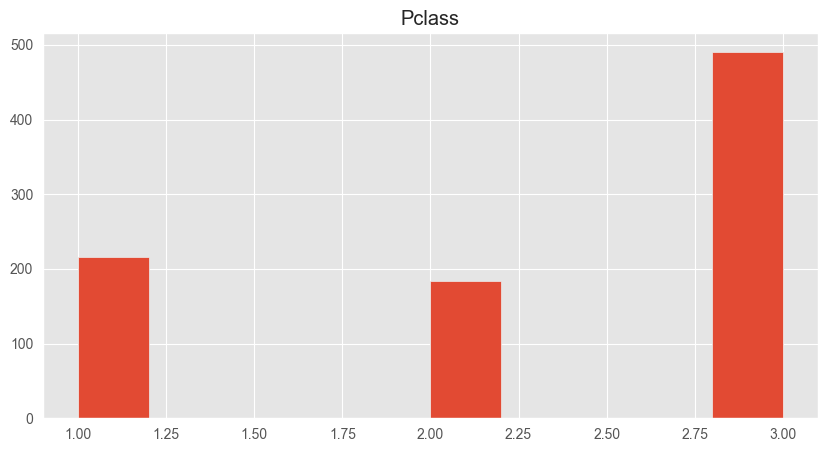

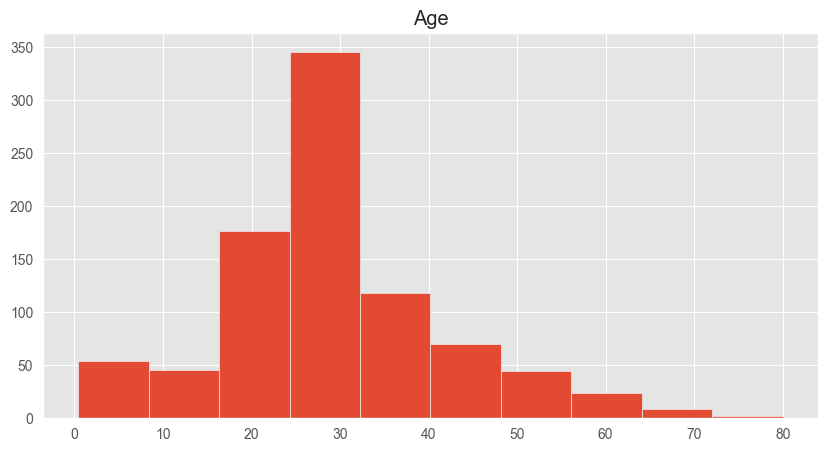

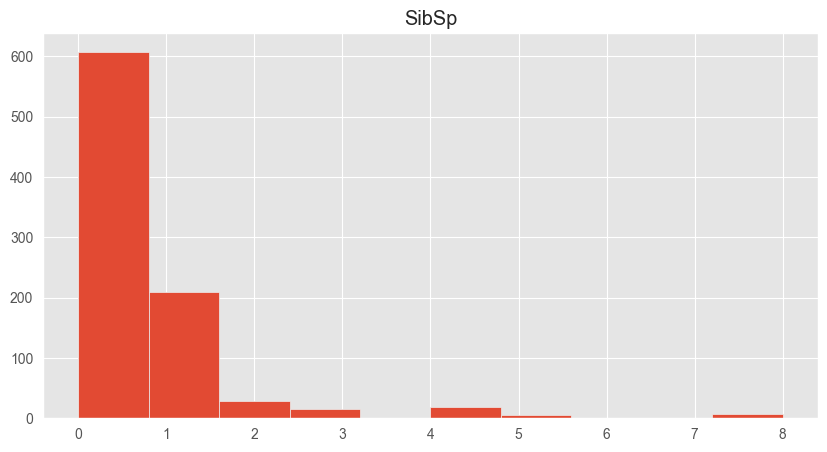

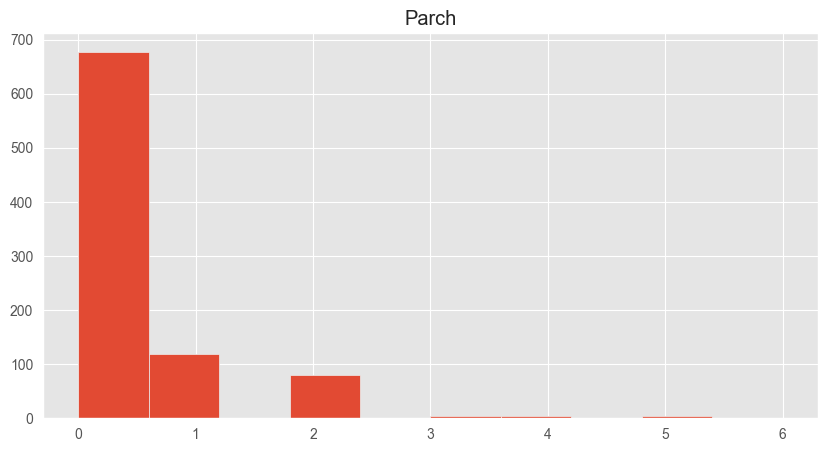

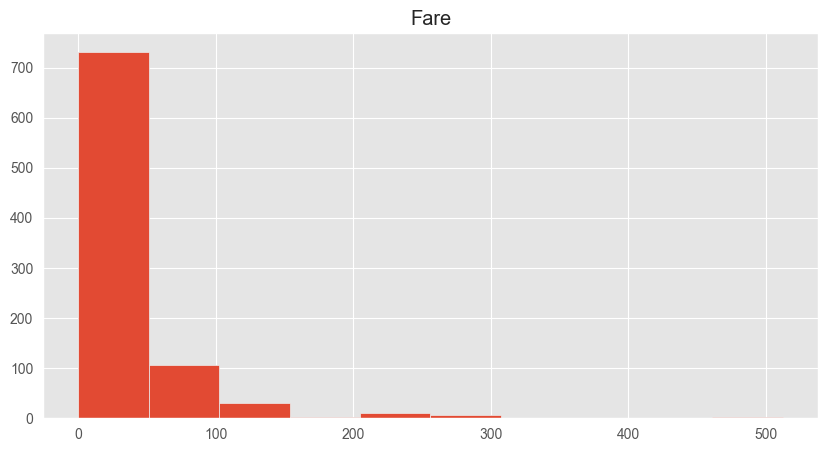

In [202]:
# I want to visualize numeric variables with histograms
numeric_cols = train.describe().columns

for col in numeric_cols[1:]:  # exclude first element because visualizing passengerid is not helpful
    plt.figure(figsize=(10, 5))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

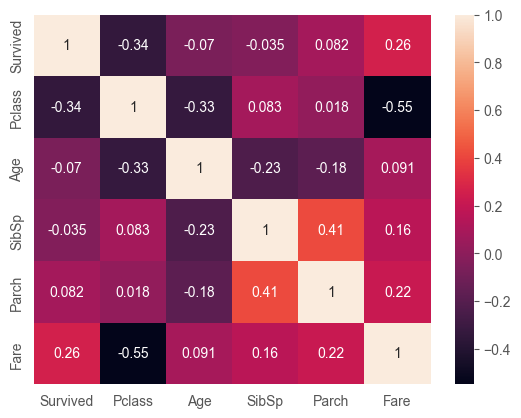

In [203]:
# correlation matrix
no_id = train.drop(["PassengerId"], axis=1)
sns.heatmap(no_id[numeric_cols[1:]].corr(), annot=True)
plt.show()

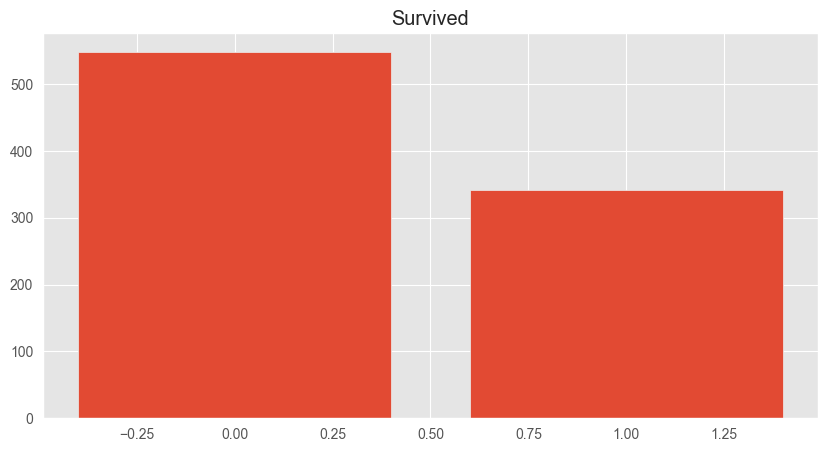

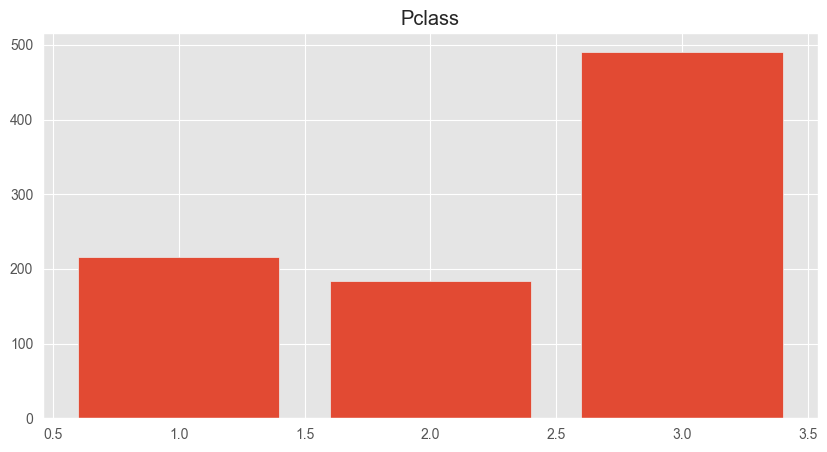

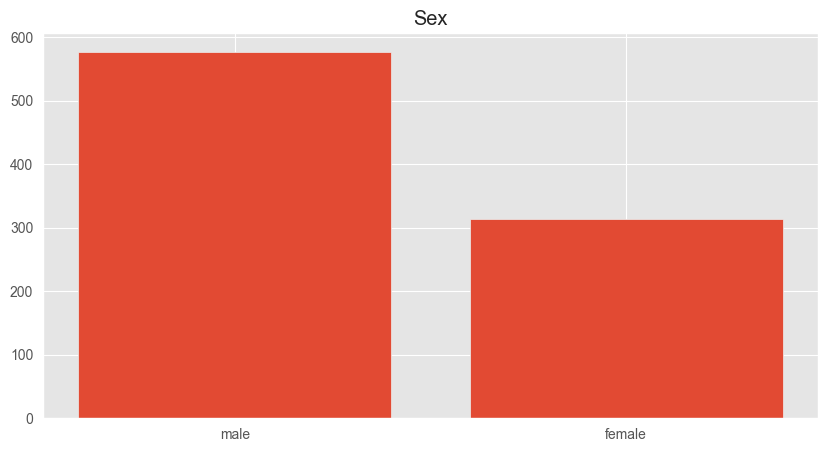

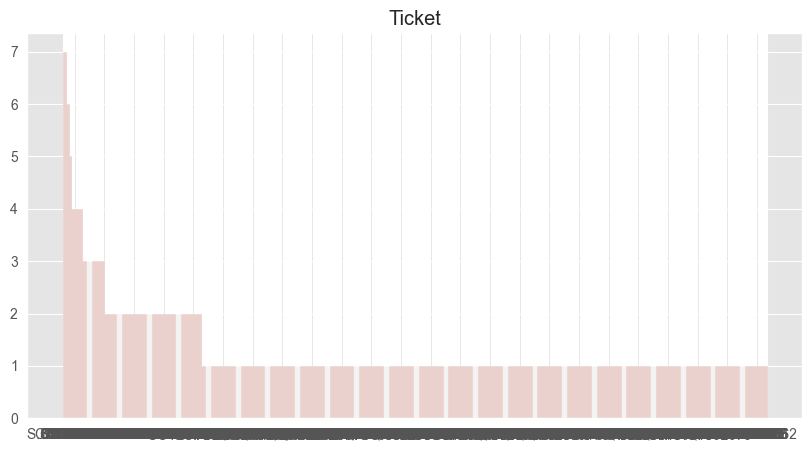

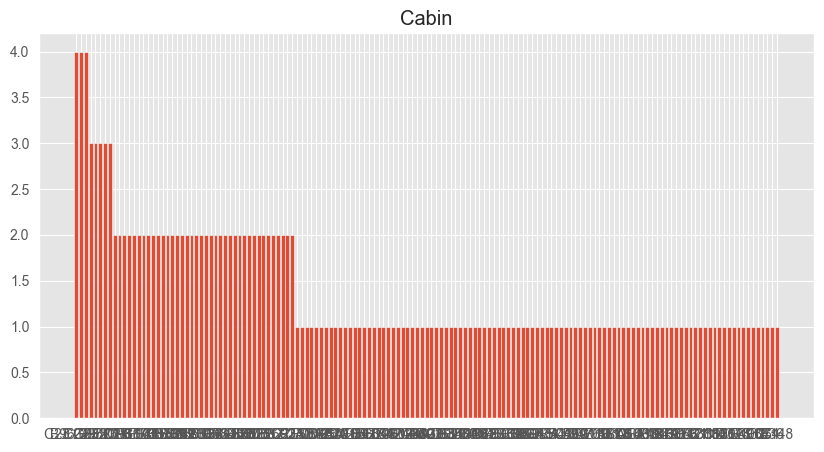

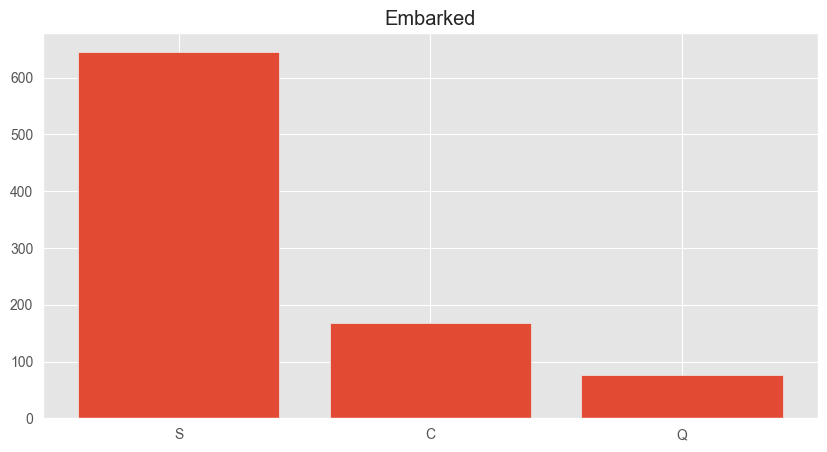

In [204]:
categorical_cols = ['Survived','Pclass','Sex','Ticket','Cabin','Embarked']
# print(categorical_cols)

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    plt.bar(train[categorical_cols][col].value_counts().index, train[categorical_cols][col].value_counts())
    plt.title(col)
    plt.show()

In [205]:
# let's do a simple test where we don't account for any categorical variables
to_drop = categorical_cols + ["PassengerId", "Survived", "Name"]
x_train1_feed = train.drop(to_drop, axis=1)
y_train1_feed = train["Survived"]
print(x_train1_feed.columns)


from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train1_feed, y_train1_feed, test_size=0.2, random_state=1)

Index(['Age', 'SibSp', 'Parch', 'Fare'], dtype='object')


In [206]:
# building first neural network
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="ReLU"),
    # tf.keras.layers.Dense(5, activation="ReLU"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

history1 = model1.fit(x_train1, y_train1, epochs=200, verbose=0)

print(model1.evaluate(x_test1, y_test1))

6/6 [==============================] - 0s 729us/step - loss: 0.6166 - accuracy: 0.6704
[0.6166303753852844, 0.6703910827636719]


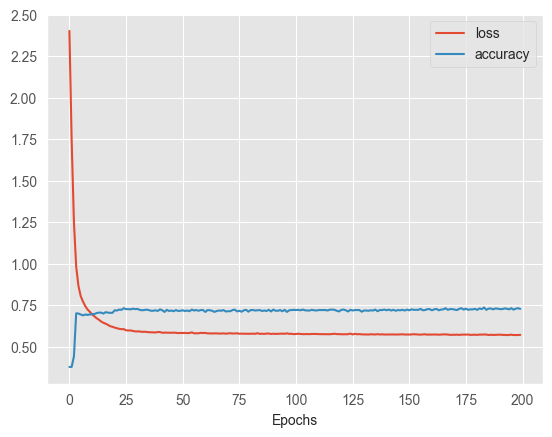

In [207]:
pd.DataFrame(history1.history).plot()
plt.xlabel("Epochs")
plt.show()

In [208]:
# let's try a better one now and deal with categorical variables

# turn sex into 1 and 0. now we can feed it to the model
train["Sex"] = train["Sex"].map(lambda sex: int(sex == "male"))
test["Sex"] = test["Sex"].map(lambda sex: int(sex == "male"))



In [209]:
# one hot encode embarked
embarked_dummies_train = pd.get_dummies(train["Embarked"], prefix="Embarked") # one-hot encode the embarked column using pd.get_dummies
train = pd.concat([train, embarked_dummies_train], axis=1) # concatenate the one-hot encoded column with the original dataframe
train = train.drop("Embarked", axis=1)

# same for test
embarked_dummies_test = pd.get_dummies(test["Embarked"], prefix="Embarked") # one-hot encode the embarked column using pd.get_dummies
test = pd.concat([test, embarked_dummies_test], axis=1) # concatenate the one-hot encoded column with the original dataframe
test = test.drop("Embarked", axis=1)
# print(train)
# print(test)


     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex        Age  SibSp  \
0                              Braund, Mr. Owen Harris    1  22.000000      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.000000      1   
2                               Heikkinen, Miss. Laina    0  26.000000      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.000000      1   
4                             Allen, Mr. William Henry    1  35.000000      0   
..                                                 ...  .

In [221]:
# what can be done with these three? Titles can be dealt with
remaining_cat = ['Ticket','Cabin', "Name"]
# print(train[remaining_cat])
# print(test[remaining_cat])
# print(train["Ticket"].value_counts())

# not sure what can be done with cabin
print(train["Cabin"].info())
print(train["Cabin"].value_counts())

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
204 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB
None
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64
